<center>
    <h1><b>Ensemble Bagging for Heart Disease Prediction</b></h1>
</center>

## Problem

 1. Load heart disease dataset in pandas dataframe
 2. Remove outliers using Z score. Usual guideline is to remove anything that has Z score > 3 or Z score -3 formular
 3. Convert text columns to numbers using label encoding and one hot encoding
 4. Apply scaling
 5. Build a classification model using support vector machine. Use standalone model as well as Bagging model and check if there is any difference in the performance.
 6. Now use decision tree classifier. Use standalone model as well as Bagging and check if there is any difference in performance.
 7. Comparing performance of svm and decision tree classifier, figure out where it makes most sense to use bagging and why. Use internet to figure out in what conditions bagging works the best

In [1]:
#Importing Libraries and APIs
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
import pickle as pk

%matplotlib inline

## Loading Dataset

In [2]:
df = pd.read_csv(r'D:\AI Engineering\Python\My_Projects\Datasets\heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Data Exploration and Processing

In [3]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [4]:
df.shape

(918, 12)

In [5]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
# List of columns
cols = df.columns.tolist()
cols

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

In [7]:
# columns with numeric values
num_cols = [col for col in df.select_dtypes(exclude = 'object').columns]

C:\Users\Banji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Banji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Banji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Banji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

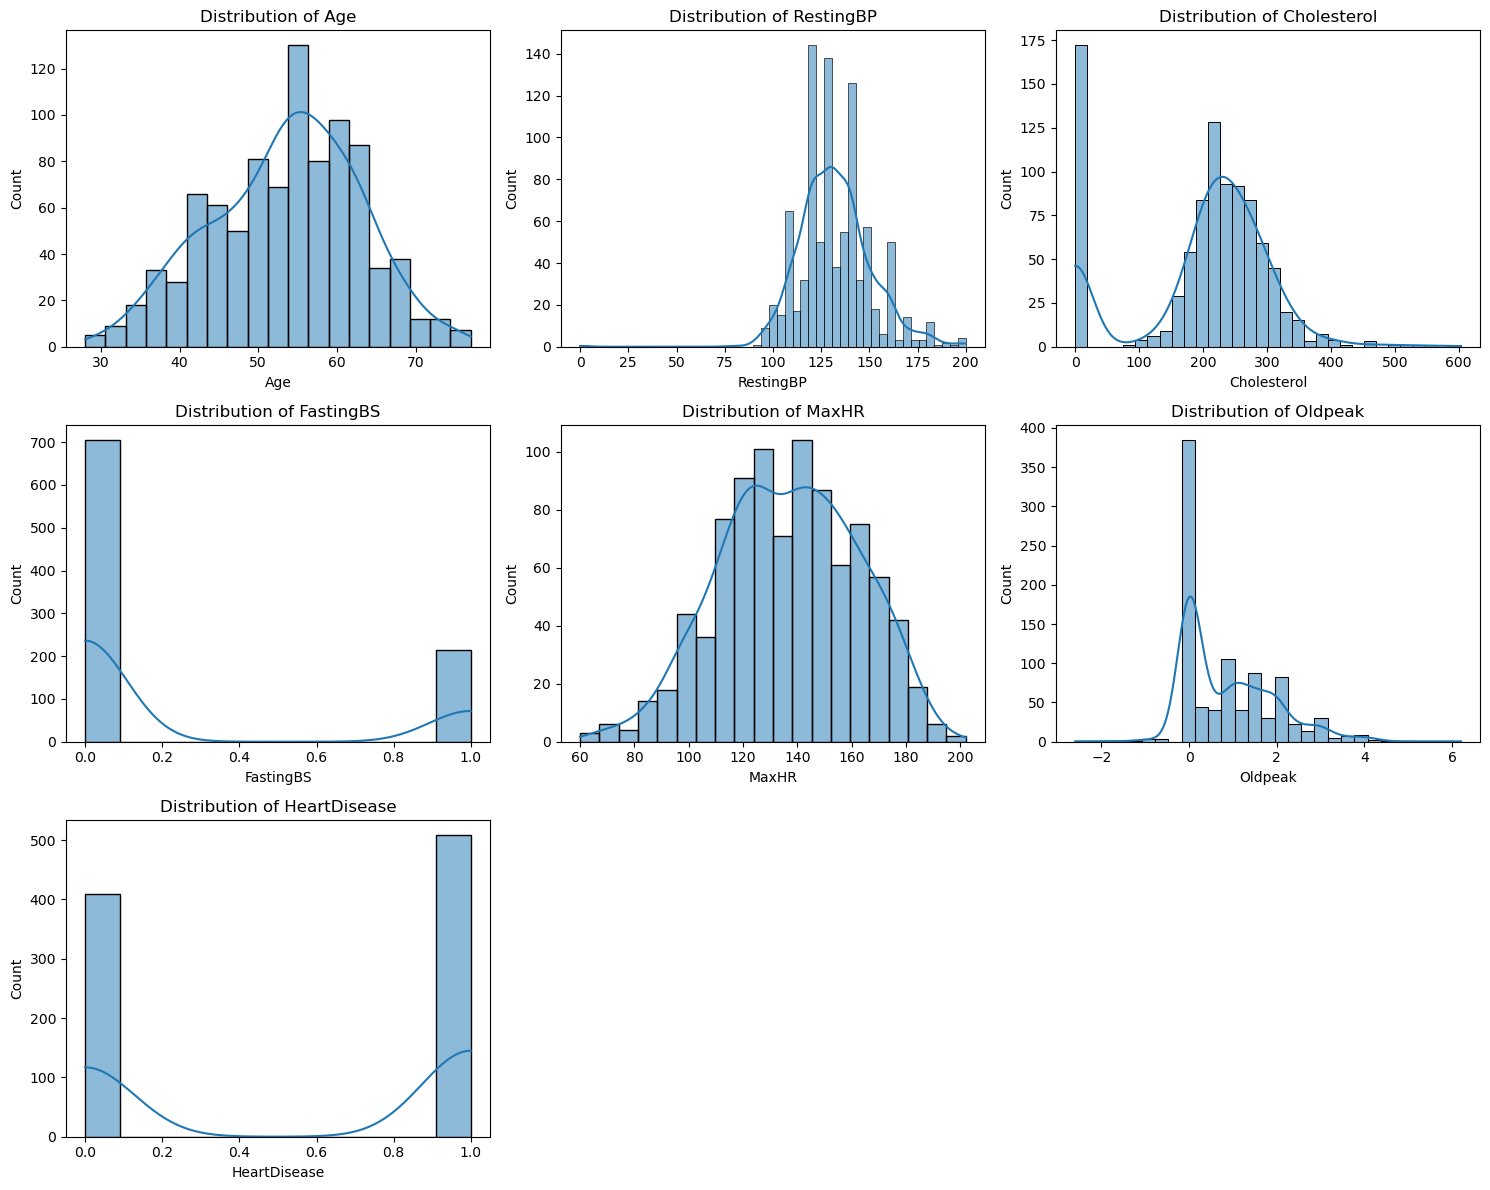

In [8]:
# Set the size of the plots
plt.figure(figsize=(15, 12))

# Loop through each column and create a histogram with KDE
for i, column in enumerate(df[num_cols], 1):
    plt.subplot(3, 3, i) 
    sb.histplot(df[column], kde=True)  # Plotting histogram with KDE
    plt.title(f'Distribution of {column}')  # title for each subplot

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


### Using z-score to find and remove outliers from some columns

From the visualization above, it can be deduced that ``'RestingBP'``, ``'Cholestol'``, and ``'OldPeak'`` columns are not distributed normally due to outliers

In [9]:
# Calculating zscore for RestingBP
df['RestingBP_zscore'] = (df['RestingBP'] - df['RestingBP'].mean()) / df['RestingBP'].std()
df[:2]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingBP_zscore
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,0.410685
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,1.490940


In [10]:
# Viewing outlier values in RestingBP column
df[(df['RestingBP_zscore'] < -3) | (df['RestingBP_zscore'] > 3)]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingBP_zscore
109,39,M,ATA,190,241,0,Normal,106,N,0.0,Up,0,3.111322
241,54,M,ASY,200,198,0,Normal,142,Y,2.0,Flat,1,3.651449
365,64,F,ASY,200,0,0,Normal,140,Y,1.0,Flat,1,3.651449
399,61,M,NAP,200,0,1,ST,70,N,0.0,Flat,1,3.651449
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1,-7.151097
592,61,M,ASY,190,287,1,LVH,150,Y,2.0,Down,1,3.111322
732,56,F,ASY,200,288,1,LVH,133,Y,4.0,Down,1,3.651449
759,54,M,ATA,192,283,0,LVH,195,N,0.0,Up,1,3.219347


In [11]:
# examining the remaining dataset after removing outliers in RestingBP_z
df_restBP = df[(df['RestingBP_zscore'] > -3) & (df['RestingBP_zscore'] < 3)]
df_restBP.shape

(910, 13)

C:\Users\Banji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


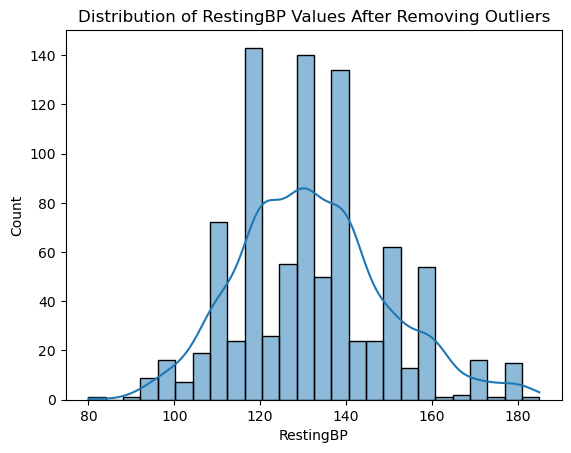

In [12]:
# Visualizing the distribution after removing outliers
sb.histplot(df_restBP['RestingBP'], kde=True)
plt.title('Distribution of RestingBP Values After Removing Outliers')
plt.show();

In [13]:
# Calculating zscore for Cholesterol
df_restBP.loc[:,'Cholesterol_zscore'] = (df_restBP['Cholesterol'] - df_restBP['Cholesterol'].mean()) / df_restBP['Cholesterol'].std()
df_restBP[:2]

C:\Users\Banji\AppData\Local\Temp\ipykernel_8984\1841163488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restBP.loc[:,'Cholesterol_zscore'] = (df_restBP['Cholesterol'] - df_restBP['Cholesterol'].mean()) / df_restBP['Cholesterol'].std()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingBP_zscore,Cholesterol_zscore
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,0.410685,0.823475
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,1.490940,-0.175198


In [14]:
# Viewing outlier values in Cholesterol column
df_restBP[(df_restBP['Cholesterol_zscore'] < -3) | (df_restBP['Cholesterol_zscore'] > 3)]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingBP_zscore,Cholesterol_zscore
76,32,M,ASY,118,529,0,Normal,130,N,0.0,Flat,1,-0.777595,3.022389
149,54,M,ASY,130,603,1,Normal,125,Y,1.0,Flat,1,-0.129442,3.700388
616,67,F,NAP,115,564,0,LVH,160,N,1.6,Flat,0,-0.939633,3.343064


In [15]:
# examining the remaining dataset after removing outliers in Cholesterol_zscore
df_chol = df_restBP[(df_restBP['Cholesterol_zscore'] > -3) & (df_restBP['Cholesterol_zscore'] < 3)]

# remove 0 and values greater than 450
df_chol = df_restBP[(df_restBP['Cholesterol'] > 0) & (df_restBP['Cholesterol']  <= 450)]
df_chol.shape

(733, 14)

C:\Users\Banji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


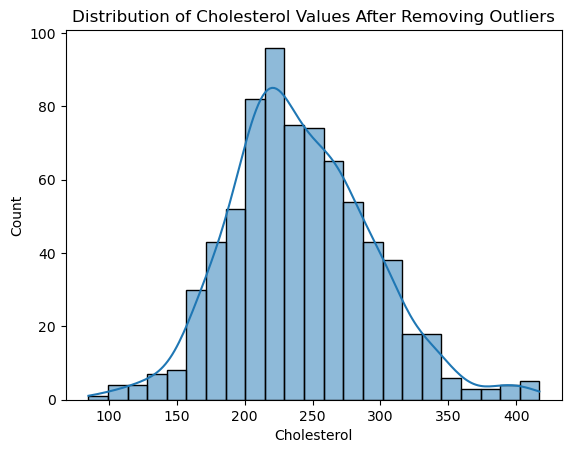

In [16]:
# Visualizing the distribution after removing outliers
sb.histplot(df_chol['Cholesterol'], kde=True)
plt.title('Distribution of Cholesterol Values After Removing Outliers')
plt.show();

In [17]:
# Calculating zscore for Cholesterol
df_chol.loc[:,'Oldpeak_zscore'] = (df_chol['Oldpeak'] - df_chol['Oldpeak'].mean()) / df_chol['Oldpeak'].std()
df_chol[:2]

C:\Users\Banji\AppData\Local\Temp\ipykernel_8984\1723908372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chol.loc[:,'Oldpeak_zscore'] = (df_chol['Oldpeak'] - df_chol['Oldpeak'].mean()) / df_chol['Oldpeak'].std()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingBP_zscore,Cholesterol_zscore,Oldpeak_zscore
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,0.410685,0.823475,-0.840480
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,1.490940,-0.175198,0.092962


In [18]:
# Viewing outlier values in Oldpeak_zscore column
df_chol[(df_chol['Oldpeak_zscore'] < -3) | (df_chol['Oldpeak_zscore'] > 3)]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingBP_zscore,Cholesterol_zscore,Oldpeak_zscore
166,50,M,ASY,140,231,0,ST,140,Y,5.0,Flat,1,0.410685,0.292071,3.826732
702,59,M,TA,178,270,0,LVH,145,N,4.2,Down,0,2.463169,0.649394,3.079978
771,55,M,ASY,140,217,0,Normal,111,Y,5.6,Down,1,0.410685,0.163801,4.386797
791,51,M,ASY,140,298,0,Normal,122,Y,4.2,Flat,1,0.410685,0.905934,3.079978
850,62,F,ASY,160,164,0,LVH,145,N,6.2,Down,1,1.490940,-0.321793,4.946862
900,58,M,ASY,114,318,0,ST,140,N,4.4,Down,1,-0.993646,1.089177,3.266666


In [19]:
# examining the remaining dataset after removing outliers in Oldpeak_zscore
df_old = df_chol[(df_chol['Oldpeak_zscore'] > -3) & (df_chol['Oldpeak_zscore'] < 3)]
df_old.shape

(727, 15)

C:\Users\Banji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


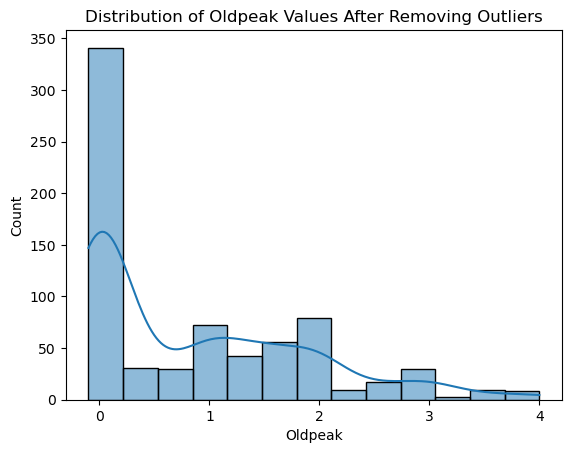

In [20]:
# Visualizing the distribution after removing outliers
sb.histplot(df_old['Oldpeak'], kde=True)
plt.title('Distribution of Oldpeak Values After Removing Outliers')
plt.show();

In [21]:
# Dropping the zscore columns
df1 = df_old.drop(columns = ['RestingBP_zscore','Cholesterol_zscore',	'Oldpeak_zscore'])

In [22]:
df1[:1]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0


### One Hot Encoding

In [23]:
label_e = LabelEncoder()

# list of columns with categorical values
cat_columns = [col for col in df1.select_dtypes(include='object').columns]
cat_columns   

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [24]:
# each column in object_col will be iterated to apply the label encoder
for col in cat_columns:
    df1[col] = label_e.fit_transform(df1[col])

In [25]:
df1[:2]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1


In [26]:
# The X variables will be selected and converted to series
X = df1.drop(columns =['HeartDisease'], axis = 1).values

# Selecting the target variable
y = df1['HeartDisease']

In [27]:
# Getting the indices of the categorical columns
cat_indices = [df1.columns.get_loc(col) for col in cat_columns]
cat_indices

[1, 2, 6, 8, 10]

In [28]:
col_transformer = ColumnTransformer(transformers = [
    ('cat', OneHotEncoder(), cat_indices)
],remainder = 'passthrough')

In [29]:
X_trans = col_transformer.fit_transform(X)

In [30]:
X_trans.shape

(727, 20)

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_trans)
X_scaled

array([[-0.56940835,  0.56940835, -0.98227535, ..., -0.44462746,
         1.29104598, -0.86046122],
       [ 1.75620889, -1.75620889, -0.98227535, ..., -0.44462746,
         0.63788632,  0.13185367],
       [-0.56940835,  0.56940835, -0.98227535, ..., -0.44462746,
        -1.72981743, -0.86046122],
       ...,
       [-0.56940835,  0.56940835,  1.01804448, ..., -0.44462746,
        -1.0358353 ,  0.33031665],
       [ 1.75620889, -1.75620889, -0.98227535, ..., -0.44462746,
         1.37269093, -0.86046122],
       [-0.56940835,  0.56940835, -0.98227535, ..., -0.44462746,
         1.33186846, -0.86046122]])

In [32]:
# Splitting the dataset nto train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify = y, test_size = 0.2, random_state = 0)

In [33]:
y_train.value_counts()

HeartDisease
0    308
1    273
Name: count, dtype: int64

In [34]:
273/308

0.8863636363636364

In [35]:
# Building model and slection of parameters
model_params = {
        'svm': {
        'model': SVC(gamma = 'scale'),
        'params': {
            'C': [1, 5, 10, 15, 20],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }
    },
        'Decision_Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
        'criterion': ["gini", "entropy", "log_loss"]
    }
}
   
}

In [36]:
scores = []
for model_name, model_para in model_params.items():
    clf = GridSearchCV(model_para['model'], model_para['params'], return_train_score = False, cv = 5)
    clf.fit(X_train, y_train)

    # Predicting the test set
    y_pred = clf.predict(X_test)

    # Storing the results
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [37]:
 # Putting the score values in a dataframe
df_score = pd.DataFrame(scores)
df_score

,model,best_score,best_params
0,svm,0.870940,"{'C': 5, 'kernel': 'rbf'}"
1,Decision_Tree,0.791851,{'criterion': 'log_loss'}


In [38]:
# Defining the bagging models and parameters
bagging_params = {
    'Bagging_SVC': {
        'model': BaggingClassifier(estimator=SVC(), random_state=0),
        'params': {
            'n_estimators': [50, 100, 200],  
            'max_samples': [0.6, 0.7, 0.8, 1.0],
            'oob_score': [True, False]
        }
    },
    'Bagging_Decision': {
        'model': BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=0),
        'params': {
            'n_estimators': [50, 100, 200],  
            'max_samples': [0.6, 0.7, 0.8, 1.0],
            'oob_score': [True, False]
        }
    }
}

In [39]:
# Training and storing results
bag_scores = []
for bag_model, bag_para in bagging_params.items():
    bag_clf = GridSearchCV(bag_para['model'], bag_para['params'], return_train_score=False, cv=5)
    bag_clf.fit(X_train, y_train)

    # Predicting the test set
    y_pred = bag_clf.predict(X_test)

    # Storing the results
    bag_scores.append({
        'model': bag_model,
        'best_score': bag_clf.best_score_,
        'best_params': bag_clf.best_params_
    })

In [40]:
for bag in bag_scores:
    print(bag)

{'model': 'Bagging_SVC', 'best_score': 0.8726348364279399, 'best_params': {'max_samples': 0.6, 'n_estimators': 200, 'oob_score': True}}
{'model': 'Bagging_Decision', 'best_score': 0.8726348364279399, 'best_params': {'max_samples': 0.7, 'n_estimators': 100, 'oob_score': True}}


In [41]:
 # Putting the baggig values in a dataframe
df_bag_score = pd.DataFrame(bag_scores)
df_bag_score

,model,best_score,best_params
0,Bagging_SVC,0.872635,"{'max_samples': 0.6, 'n_estimators': 200, 'oob..."
1,Bagging_Decision,0.872635,"{'max_samples': 0.7, 'n_estimators': 100, 'oob..."


In [42]:
# Selecting the best model to save
best_model = None
best_score = 0

for bag_model, bag_para in bagging_params.items():
    bag_clf = GridSearchCV(bag_para['model'], bag_para['params'], return_train_score=False, cv=5)
    bag_clf.fit(X_train, y_train)

    # Predicting the test set
    y_pred = bag_clf.predict(X_test)

    # Storing the results
    bag_scores.append({
        'model': bag_model,
        'best_score': bag_clf.best_score_,
        'best_params': bag_clf.best_params_
    })

# Trackng the best model across all iterations
    if clf.best_score_ > best_score:
        best_score = clf.best_score_
        best_model = clf.best_estimator_

print(f'The best model overall is: {best_model}')

The best model overall is: DecisionTreeClassifier(criterion='log_loss')


## Confusion Matrix

In [43]:
# Calculating confusion matrix for the best model

best_model = best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
cm

array([[63, 14],
       [17, 52]], dtype=int64)

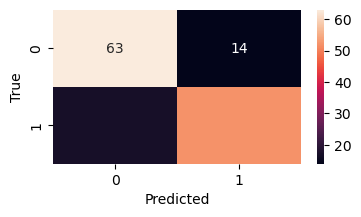

In [44]:
# Visualizing the confusion matrix
plt.figure(figsize =[4, 2])
sb.heatmap(cm, annot = True)
plt.xlabel("Predicted")
plt.ylabel('True');

## Saving the Best Model

In [45]:
# Saving the model as a pickle file
with open('model_heart_bagging.pkl', 'wb') as f:
    pk.dump(best_model, f)